## Notebook 2: Segmentation of satellite images of water bodies using pretrained Resnet-50 model in Pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset used in this notebook is a collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water. The masks were created to detect and measure vegetation in satellite images.

In this notebook, I applied the pretrained DeepLabV3 ResNet-50 model in Pytorch to perform segmentation on the water body images. I chose the DeepLabV3 semantic segmentation architecture because of its effectiveness and simplicity.

**1. Prepare Problem**

In [2]:
# a) Load libraries
import os
import glob
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import cv2
!pip install imagehash
import imagehash

import torchvision.models.segmentation
import torch
import torchvision.transforms as tf

from sklearn.model_selection import train_test_split
from PIL import Image

from pickle import dump

# Check if GPU parallel computing is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 8.2 MB/s eta 0:00:00
cuda


In [3]:
# b) Prepare dataset
# Here I selected large images height and width to improve training performance
height = width = 500
batch = 11

images_list = sorted(glob.glob("/content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/*.jpg"))
masks_list = sorted(glob.glob("/content/drive/MyDrive/RcNN/Water Bodies Dataset/Masks/*.jpg"))

print(len(images_list), len(masks_list))

2841 2841


In total, there are 2,841 photos in each Images and Masks folders.

**2. Exploratory Data Analysis**

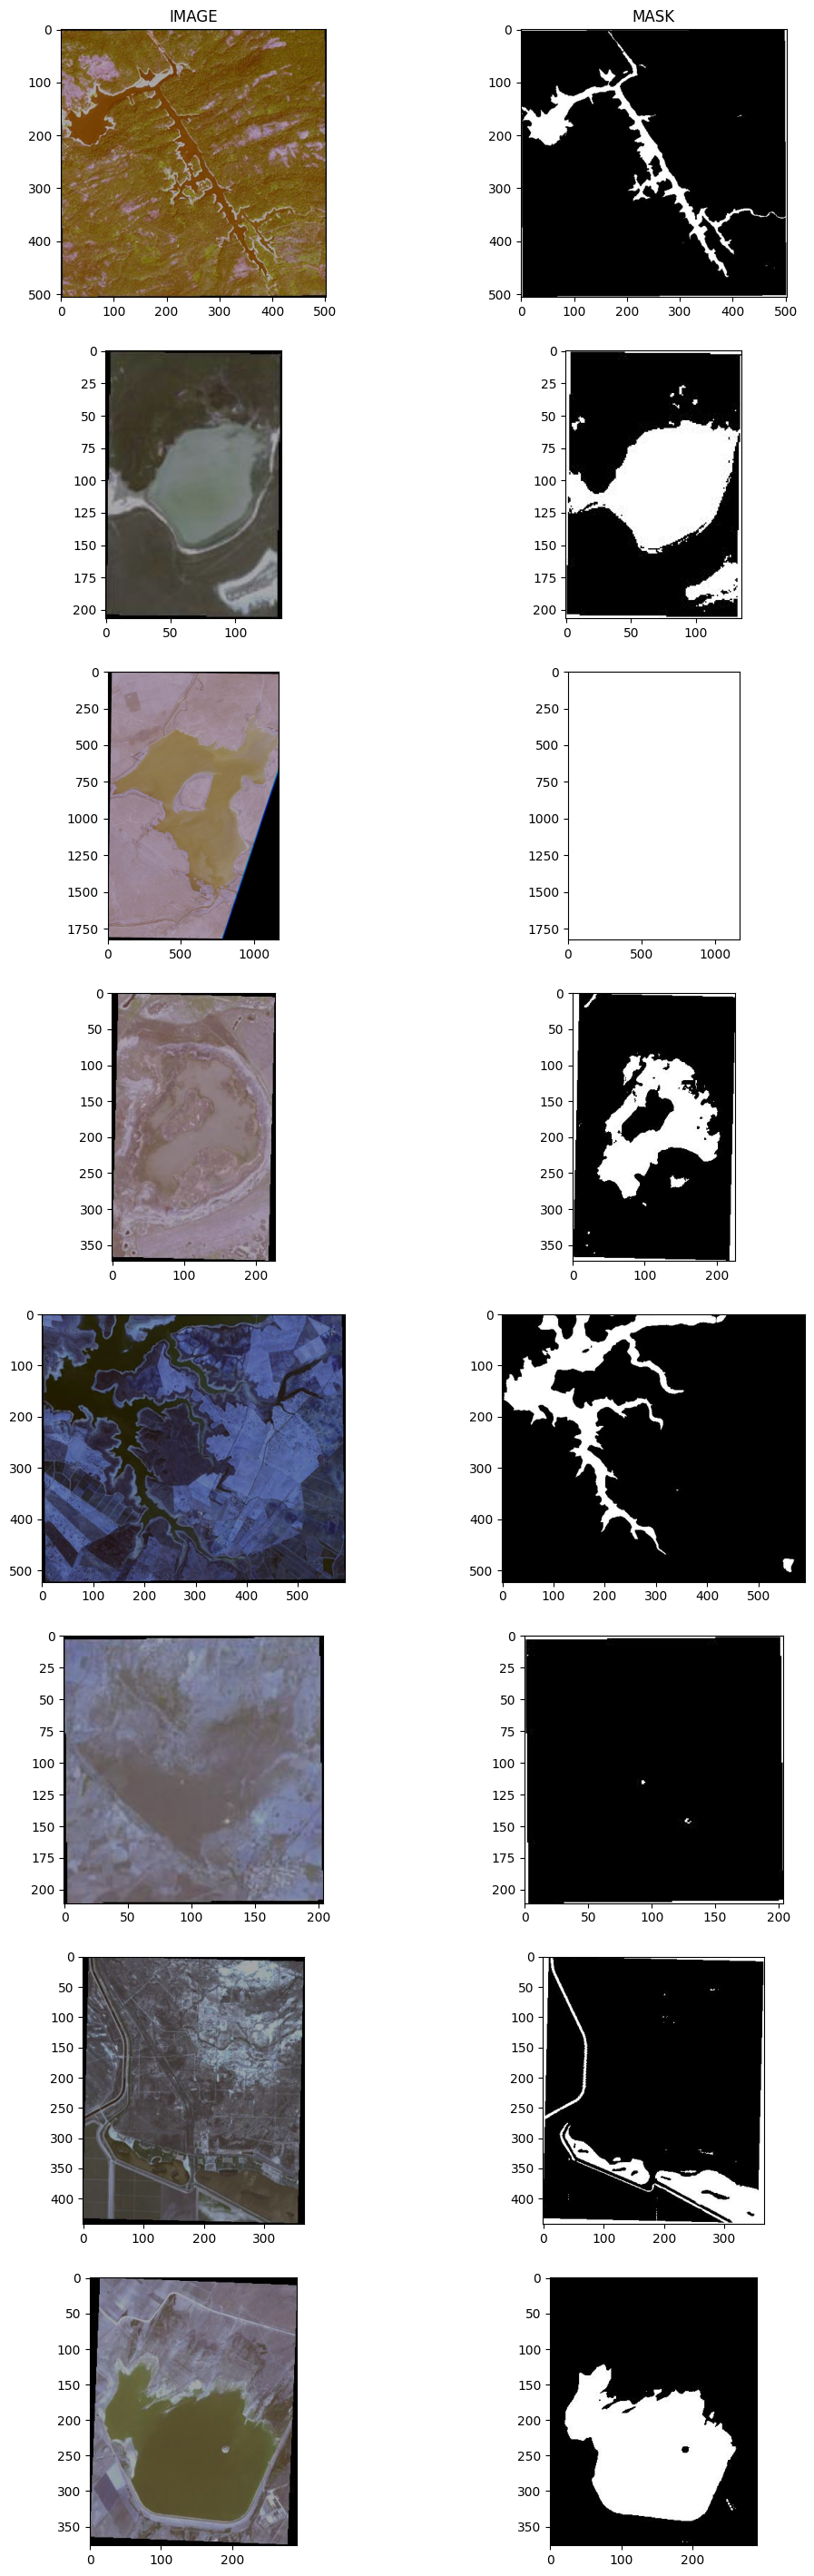

In [4]:
# a) Image visualization
# plot first few images in Images and Masks folder
f, axr = plt.subplots(8, 2, figsize=(12, 36))
for i in range(8):
    idx = np.random.randint(0, len(images_list))
    original = cv2.imread(images_list[idx])
    mask = cv2.imread(masks_list[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask, cmap = 'gray')
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

We can see images and masks come with different shapes and even blank masks. These factors may present challenges during the transformation and training processes.

Let's examine the statistical figures of the dataset to understand how the dimensions are distributed among the images. This will help us identify any abnormal size images that can be filtered out to improve training performance.

In [5]:
# Calculate statistics of the image dimensions
dimen_img_list = []
count=0
for img in images_list:
    count=count+1
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    print(count)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

# Convert the list to numpy array
dimen_img_array = np.array(dimen_img_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# Calculate statistics of the image dimensions
print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 5
Maximum width: 5640
Mean width: 446.15654615654614
Median width: 260.0
Standard deviation of width: 554.0990087890764
Minimum height: 7
Maximum height: 7093
Mean height: 561.7879957879958
Median height: 334.0
Standard deviation of height: 689.5166868738714


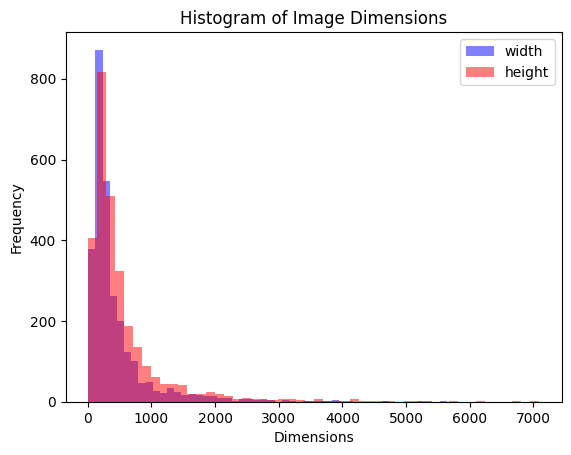

In [6]:
# Plot the histogram
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

The statistical result suggests that the median values of height and width of the images are around 300 pixels and therefore, it would be advisable to resize all images and masks to this size or larger to ensure good training performance. To filter out any images with abnormal sizes, a cut-off threshold of 32 pixels (which is 10% of the median value) will be applied.

**3. Prepare Data**

In [7]:
# a) Data Cleaning

#Detect duplicate images and masks
hashes = {}
to_remove = []

for file in images_list:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)
            # Compute the hash value for the image
            h = imagehash.phash(img)

            # Check if the hash value already exists in the dictionary
            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("/content/drive/MyDrive/RcNN/Water Bodies Dataset/Images", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file


Duplicate image found: /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1244.jpg and /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1333.jpg and /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1552.jpg and /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1619.jpg and /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1659.jpg and /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/RcNN/Water Bodies Dataset/Images/water_body_2312.jpg and /c

After removing 17 duplicate images and their corresponding masks, new lists of images and masks were created for the next stage of data processing.

In [8]:
# Create a new list of filenames that excludes the duplicates
new_images_list = [file for file in images_list if file not in to_remove]
new_masks_list = [os.path.join("/content/drive/MyDrive/RcNN/Water Bodies Dataset/Masks", os.path.basename(file)) for file in new_images_list]
print(len(new_images_list), len(new_masks_list))

2824 2824


In [9]:
# a) Load, filter blank and abnormal size images and masks
import cv2
import numpy as np

# Resize image to a fixed size
def resize_image(image, target_size=(128, 128)):
    if image is not None and not np.all(image == 0):
        resized_image = cv2.resize(image, target_size)
        return resized_image
    else:
        return None

# Load, filter blank and abnormal size images and masks
min_size = 32
df_images = []
df_masks = []
count=0
for img, mask in zip(new_images_list, new_masks_list):
    n = cv2.imread(img, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    # Resize images to a fixed size
    n_resized = resize_image(n)
    m_resized = resize_image(m)
    count=count+1
    print(count)
    # Check if the resized images are valid
    if n_resized is not None and m_resized is not None:
        # Check if the image has size > min_size and isn't entirely black or white
        if min(n_resized.shape[:2]) > min_size and (np.any(np.asarray(m_resized) != 0) and np.any(np.asarray(m_resized) != 255)):
            df_images.append(n_resized)
            df_masks.append(m_resized)

# Convert lists to numpy arrays
df_images = np.array(df_images)
df_masks = np.array(df_masks)

print(len(df_images), len(df_masks))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In total, 126 images and their corresponding masks were removed from the dataset, leaving a total of 2698 samples for training, testing, and validation.

In [10]:
# Create a preprocessing pipeline for images and masks
tfImg = tf.Compose([
        tf.ToPILImage(),
        tf.Resize((height, width)),
        tf.ToTensor(),
        tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
tfMsk = tf.Compose([
        tf.ToPILImage(),
        tf.Resize((height, width)),
        tf.ToTensor(),
        ])

In [11]:
# Create a function to read images and masks randomly
def ReadImage(df_images, df_masks):
    idx = np.random.randint(0, len(df_images))
    Img = tfImg(df_images[idx])
    Msk = tfMsk(df_masks[idx])
    return Img, Msk

In [12]:
# Create a function to load images and masks in batch
def LoadBatch(df_images, df_masks):
    images = torch.zeros([batch, 3, height, width])
    masks = torch.zeros([batch, height, width])
    for i in range(batch):
        images[i], masks[i] = ReadImage(df_images, df_masks)
    return images, masks

In [13]:
# a) Split data into train, test and validation sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2038, 128, 128, 3) (2038, 128, 128) (669, 128, 128, 3) (669, 128, 128) (11, 128, 128, 3) (11, 128, 128)


**4. Evaluate Models**

In [14]:
# a) Define pretrained ResNet-50 model using TorchVision DeepLabV3 architecture
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained = True)

# Since the segmented images have 2 classes (black and white), we change the final layer to 2 classes
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size = (1, 1), stride = (1, 1))
model = model.to(device)

# Select Stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 (optimum for image segmentation)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 157MB/s]


In [15]:
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
Losses = []

In [28]:
# b) Evaluation of train dataset
epochs = 1200

# Training loop
for itr in range(epochs):
   images, masks = LoadBatch(X_train, y_train)
   # Load images and masks tensors to the GPU
   images = torch.autograd.Variable(images,requires_grad = False).to(device)
   masks = torch.autograd.Variable(masks, requires_grad = False).to(device)

   # Forward training loop
   Pred = model(images)['out']
   model.zero_grad()
   Loss = criterion(Pred, masks.long())
   Losses.append(Loss.item())

   # Backward training loop
   Loss.backward()
   optimizer.step() # Apply gradient descent to optimize weights
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy() # Move the tensor to the CPU, detach it from the graph, and convert it to a NumPy array
   print(itr,") Loss=", Loss.data.cpu().numpy())

0 ) Loss= 0.25783604
1 ) Loss= 0.40774736
2 ) Loss= 1.01253
3 ) Loss= 0.73210484
4 ) Loss= 0.44888544
5 ) Loss= 0.42212504
6 ) Loss= 0.3180311
7 ) Loss= 0.26366326
8 ) Loss= 0.29908857
9 ) Loss= 0.349845
10 ) Loss= 0.21506257
11 ) Loss= 0.21555062
12 ) Loss= 0.27287522
13 ) Loss= 0.2507541
14 ) Loss= 0.16126134
15 ) Loss= 0.19299023
16 ) Loss= 0.18876578
17 ) Loss= 0.35416225
18 ) Loss= 0.209442
19 ) Loss= 0.22889027
20 ) Loss= 0.31517172
21 ) Loss= 0.17960586
22 ) Loss= 0.28790143
23 ) Loss= 0.30303863
24 ) Loss= 0.5179501
25 ) Loss= 0.30356574
26 ) Loss= 0.29178092
27 ) Loss= 0.31794953
28 ) Loss= 0.21608019
29 ) Loss= 0.33303759
30 ) Loss= 0.28996414
31 ) Loss= 0.28849348
32 ) Loss= 0.18140931
33 ) Loss= 0.29058054
34 ) Loss= 0.20127995
35 ) Loss= 0.24086131
36 ) Loss= 0.27700838
37 ) Loss= 0.16451466
38 ) Loss= 0.19428961
39 ) Loss= 0.23859586
40 ) Loss= 0.208089
41 ) Loss= 0.17816411
42 ) Loss= 0.28285983
43 ) Loss= 0.22373734
44 ) Loss= 0.1911798
45 ) Loss= 0.2824657
46 ) Loss= 0

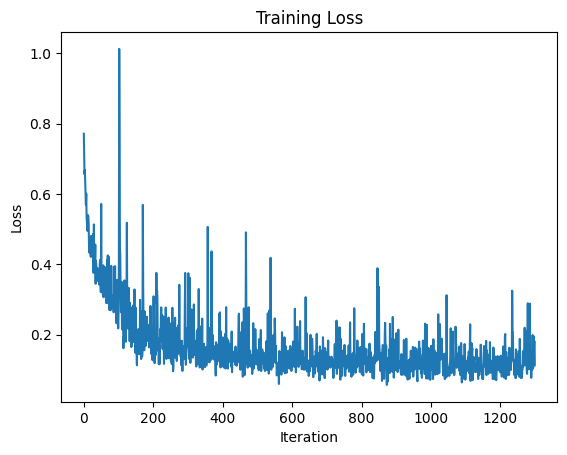

In [29]:
# Plot the training loss values
plt.plot(Losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

The results of training the model show that the loss values were slightly better than the TensorFlow model (0.12 vs. 0.34). It seems that the optimal number of epochs for achieving good loss values is around 1000, and increasing the number of epochs beyond this point does not significantly improve training performance.

Now that the model has been trained, we can proceed to testing it with new images.

In [30]:
# Set trained model to the evaluation mode for validation test set
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [31]:
Losses_test = []

with torch.no_grad(): # Set context to not calculate and save gradients
  correct = 0
  total = 0
  for itr in range(epochs):
   images_test, masks_test = LoadBatch(X_test, y_test)
   # Load images and masks tensors to the GPU
   images_test = torch.autograd.Variable(images_test,requires_grad = False).to(device)
   masks_test = torch.autograd.Variable(masks_test, requires_grad = False).to(device)

   Pred_test = model(images_test)['out']
   model.zero_grad()
   Loss_test = criterion(Pred_test, masks_test.long())
   Losses_test.append(Loss_test.item())

   seg = torch.argmax(Pred_test[0], 0).cpu().detach().numpy() # Move the tensor to the CPU, detach it from the graph, and convert it to a NumPy array
   print(itr,") Loss=", Loss_test.data.cpu().numpy())

0 ) Loss= 0.14074767
1 ) Loss= 0.18650559
2 ) Loss= 0.18492779
3 ) Loss= 0.17021413
4 ) Loss= 0.11055573
5 ) Loss= 0.16778079
6 ) Loss= 0.11456762
7 ) Loss= 0.19159168
8 ) Loss= 0.15003835
9 ) Loss= 0.19639741
10 ) Loss= 0.14608409
11 ) Loss= 0.13196576
12 ) Loss= 0.1800972
13 ) Loss= 0.23101853
14 ) Loss= 0.12938847
15 ) Loss= 0.39315146
16 ) Loss= 0.159826
17 ) Loss= 0.14791276
18 ) Loss= 0.13248463
19 ) Loss= 0.18520267
20 ) Loss= 0.08250947
21 ) Loss= 0.11358707
22 ) Loss= 0.20465524
23 ) Loss= 0.1812153
24 ) Loss= 0.16213785
25 ) Loss= 0.14217788
26 ) Loss= 0.16685237
27 ) Loss= 0.16325334
28 ) Loss= 0.2182591
29 ) Loss= 0.22970861
30 ) Loss= 0.10424325
31 ) Loss= 0.16468012
32 ) Loss= 0.16045703
33 ) Loss= 0.09193325
34 ) Loss= 0.14410648
35 ) Loss= 0.1424729
36 ) Loss= 0.20953684
37 ) Loss= 0.1544463
38 ) Loss= 0.17553088
39 ) Loss= 0.108551525
40 ) Loss= 0.1932966
41 ) Loss= 0.10092939
42 ) Loss= 0.11892372
43 ) Loss= 0.18432736
44 ) Loss= 0.15599039
45 ) Loss= 0.1514312
46 ) L

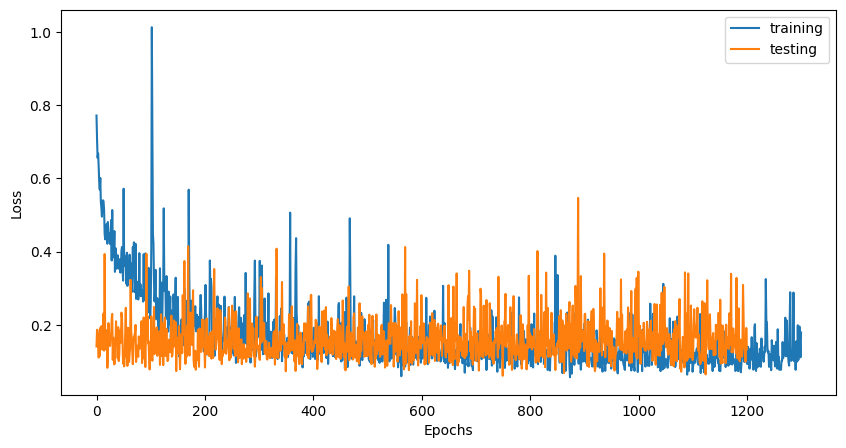

In [32]:
# Plot the training loss values
plt.figure(figsize = (10, 5))
plt.plot(Losses, label = 'training')
plt.plot(Losses_test, label = 'testing')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The consistency between the training and validation losses suggests that the model is capable of accurately predicting on new data.

**5. Finalize Model**

In [33]:
import torch
from sklearn.metrics import accuracy_score

# Determine the device (CUDA if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the chosen device
model.to(device)

def calculate_accuracy(X_test, y_test, model):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    # Iterate over the test data
    with torch.no_grad():
        for i in range(len(X_test)):
            # Convert the input data to PyTorch tensors and move to the chosen device
            image = torch.tensor(X_test[i]).unsqueeze(0).permute(0, 3, 1, 2).to(device).float()  # Convert to float
            mask = torch.tensor(y_test[i]).to(device).float()  # Convert to float

            # Forward pass to get model predictions
            output = model(image)

            # Access the 'out' key in the model's output
            # Usually, segmentation models output an OrderedDict, with the 'out' key containing the segmentation results
            output_tensor = output['out'] if isinstance(output, dict) else output

            # Get the predicted class (argmax along the class dimension)
            _, predicted_class = torch.max(output_tensor, 1)

            # Add the predicted class to the list of predictions
            y_pred.append(predicted_class.cpu().numpy().flatten())  # Flatten for comparison

    # Flatten ground truth masks and predicted masks for accuracy calculation
    y_true = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

# Calculate accuracy for the test dataset
accuracy = calculate_accuracy(X_test, y_test, model)
print(f'Accuracy: {accuracy * 100:.2f}%')







Accuracy: 58.66%


In [34]:
# a) Predictions on validation data
Pred_val = []
with torch.no_grad(): # Set context to not calculate and save gradients
    for i in X_val:
        Img_tensor = tfImg(i)
        # Load tensor images to GPU
        Img_tensor = torch.autograd.Variable(Img_tensor, requires_grad = False).to(device).unsqueeze(0)
        Pred2 = model(Img_tensor)['out']
        Pred_val.append(Pred2)

In [35]:
pred_np_list = []
for i in range(len(Pred_val)):
    #Get original shape of images in X_val
    height_orgin, width_orgin, d = X_val[i].shape
    pred_tensor = Pred_val[i]
    # Resize segmented images to origninal sizes
    pred_resized = tf.Resize((height_orgin,width_orgin))(pred_tensor[0])
    #Convert the tensor image to a numpy array
    pred_np = pred_resized.cpu().detach().numpy()
    pred_np_list.append(pred_np)

In [36]:
# Plot original and predicted images
fig, ax = plt.subplots(len(X_val), 3, figsize=(12,40))
for i in range(len(X_val)):
    orig = X_val[i]
    msk = y_val[i]
    seg = pred_np_list[i][1, :, :]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk, cmap='gray')
    ax[i,2].imshow(seg, cmap='gray')
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

Output hidden; open in https://colab.research.google.com to view.

The trained model appears to be effective at performing segmentation on new images that it was not trained on.

In [37]:
# b) Save the model for later use
# save the best model's weights to a file for future inference
torch.save(model.state_dict(), "best_model.pth")

**6. Conclusions**

- Data cleaning is essential to remove duplicate, blank and abnormal size images.

- Increasing the size of the images, batch size, the number of epochs and size of dataset can enhance the performance of the training process.

- The DeepLabV3 architecture is a simple and highly effective pretrained model for semantic segmentation in pytorch.

- When comparing the validation loss of the pretrained Resnet-50 model in Pytorch to that of the Keras model (0.12 vs. 0.34), we can see the computational demands of the DeepLabV3 model are significantly higher but its prediction accuracy is about the same as the Keras model.